# Pytorch Workflow
1. Get the data ready
2. Build or pick a pretrained model that suits your problem
    - Pick a loss function and optimizer
    - Build a training loop
3. Fit the model to the data and make predictions
4. Evaluate the model
5. Improve through experimentation
6. Save and reload your trained model

In [200]:
import matplotlib.pyplot as plt
from torch import nn
import torch

`nn` contains all of pytorch's building blocks for neural networks

Reference: to https://pytorch.org/docs/stable/nn.html

### Preparing and Loading Our Data

Machine learning is a game of 2 parts:
1. Get data into numerical representation
2. Build a model to learn that numerical representations

In [201]:
weight = 0.7
bias = 0.3

In [202]:
X = torch.arange(0,1, 0.02).unsqueeze(dim=1)
y = weight * X + bias

In [203]:
y.shape, X.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

### Split the data into train and test sets
There are 2 ways we could do this
1. using our custom defined function to do this or using 
2. The scikit learn train_test_split function

In [204]:
# Using our custom defined function to do this or using
def split_data(X, y, train_size):
    X_train = X[:int(len(X)*train_size)]
    X_test = X[len(X_train):]
    y_train = y[:int(len(y)*train_size)]
    y_test = y[len(y_train):]
    
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = split_data(X, y, .8)

In [205]:
# The scikit learn train_test_split function, this one adds a bit of randomness to our data which what we want.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)

In [206]:
import pandas as pd

In [207]:
# Convert our data into a more structured format
X = X.squeeze()
y = y.squeeze()
data = pd.DataFrame({'X':X, 'y':y})
data.head()

,X,y
0,0.00,0.300
1,0.02,0.314
2,0.04,0.328
3,0.06,0.342
4,0.08,0.356


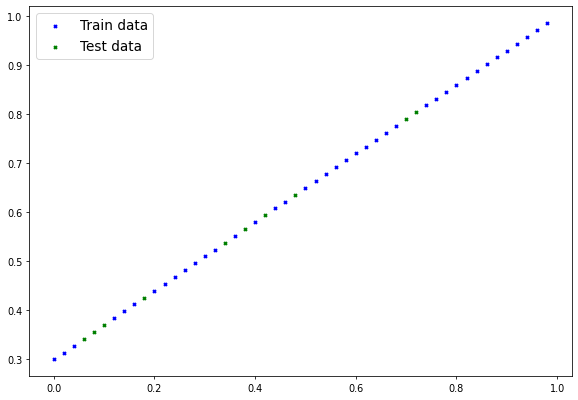

In [208]:
def plot_prediction(train_data=X_train, 
                    train_label=y_train, 
                    test_data=X_test, 
                    test_label=y_test, 
                    prediction=None):
    """Plots a scatter plot of train, test and prediction data"""

    # plot the train data
    plt.figure(figsize=(10, 7))
    plt.rcParams['figure.dpi'] = 70
    plt.scatter(train_data, train_label, c='b', marker='X', s=10, label='Train data')

    # plot the test data
    plt.scatter(test_data, test_label, c='g', marker='X', s=10, label='Test data')

    # plot the prediction
    if prediction is not None:
        plt.scatter(test_data, prediction, c='r', marker='X', s=10, label='Predictions')

    plt.legend(prop={'size': 14});

plot_prediction()

## Linear Regression Modelling in Pytorch

In [209]:
# create a linear regression pytorch class
class LinearRegressionModel(nn.Module):
    # create a constructor
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
    
    # Forward defines the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

`torch.optim` - Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).

In [210]:
# Create a manual seed
torch.manual_seed(42)

# Instantiate our model
model_0 = LinearRegressionModel()

In [211]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [212]:
model_0.state_dict() #list the named parameters (In our case self.weight and self.bias with their respective values)

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Make Predictions with Our Model using `torch.infrence_mode()`

In [213]:
with torch.inference_mode():
    y_pred = model_0(X_test)

y_pred

tensor([[0.2433],
        [0.2568],
        [0.2702],
        [0.1557],
        [0.2904],
        [0.3712],
        [0.1490],
        [0.3645],
        [0.1894],
        [0.1625]])

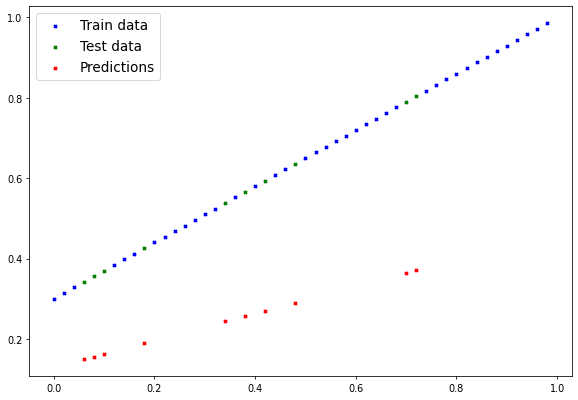

In [214]:
plot_prediction(prediction=y_pred)

### Loss Functions and Optimizers

In [215]:
# Now the next thing to do is to setup a loss function to evaluate the performance of our model.
# The loss function will help us understand how far our model's predictions are from the true values
# Pytorch has bunch of loss functions to pick from depending on the problem we are solving 

# reference: https://pytorch.org/docs/stable/nn.html#loss-functions
# There are over 20 of them
# we are going to use the Mean Absolute Error for our evaluation, Note: pytorch calls this the L1Loss (Creates a criterion that measures the mean absolute error (MAE) between each element in the input xxx and target yyy.)

# setup the loss function
loss_fn = nn.L1Loss()

In [216]:
# Next is to setup our optimizer, think of the optimizer as a car speed regulator that tells a car/owner what best gear to use during acceleration. I can't think any better, lol.

# Basically it tell the models how to best adjusts its weight and biases in other to improve the loss function (reduce the loss)

# reference: https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer

# setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

### Build a Training and Testing Loop

**Steps:**
1. Loop through the data
2. Make a forward propagation (by calling the forward method in our model's class)
3. Calculate the loss by compairing forward pass prediction to the ground truth
4. Optimize zero grad
5. Loss backward (Move backwards through the network to calculate the gradient of each of the parameters)
6. Optimizer step (Use the optimizer to adjust the parameters to improve the loss function)

In [261]:
epochs = 200 #number of loops through the data
epoch_count = []
loss_values = []
test_loss_values = []

# 1. Loop through the data
torch.manual_seed(42)
for epoch in range(epochs):
    # set the model to training mode
    model_0.train()

    # 2. Forward propagation
    y_pred = model_0(X_train)

    # 3. Calculate the loss 
    loss = loss_fn(y_pred, y_train)

    # 4. Optimize zero grad
    optimizer.zero_grad()

    # 5. Loss Backward (Back propagation)
    loss.backward()

    # 6. Optimizer Step (Adjust the parameters to improve the loss function)
    optimizer.step()


    ## TESTING

    # Turn off gradient tracking
    model_0.eval()

    # print the model parameters
    # print(model_0.state_dict())

    with torch.inference_mode():
        # perform the forward propagation
        test_pred = model_0(X_test)

        # calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch%10 == 0:
        print(f'Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}')
        # track our model loss and test loss
        epoch_count.append(epoch)
        loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())

Epoch: 0 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 10 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 20 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 30 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 40 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 50 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 60 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 70 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 80 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 90 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 100 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 110 | Train Loss: 0.00032505913986824453 | Test Loss: 0.0007479816558770835
Epoch: 120 | Tr

In [262]:
# lets make some predictions using the inference mode
with torch.inference_mode():
    y_pred_new = model_0(X_test)

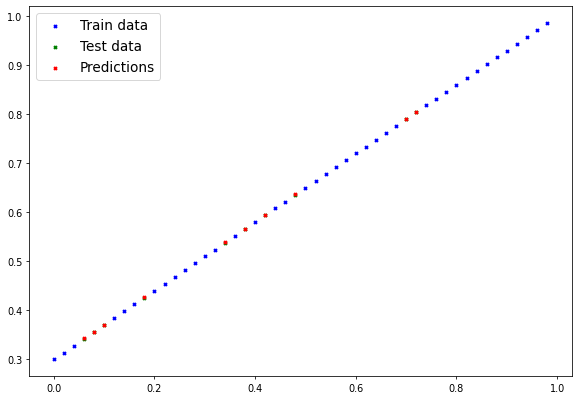

In [263]:
plot_prediction(prediction=y_pred_new)

In [264]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6994])), ('bias', tensor([0.3006]))])

In [265]:
weight, bias

(0.7, 0.3)

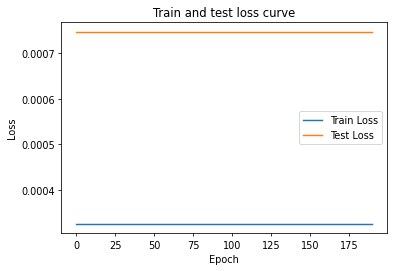

In [266]:
# create a function to plot our loss curves 

def plot_loss_curve(loss_values=loss_values, test_loss_values=test_loss_values):
    # plot the train loss curve
    plt.plot(epoch_count, loss_values, label='Train Loss')

    # plot the test loss curve
    plt.plot(epoch_count, test_loss_values, label='Test Loss')

    # add a title
    plt.title('Train and test loss curve')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()


plot_loss_curve()